## Import Libs

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib
import os
import warnings
from pathlib import Path


warnings.filterwarnings('ignore')

## Importa base

In [2]:
# Mapeia link do csv no git
url = "https://raw.githubusercontent.com/geoferreira1/fiap_tech_challenge_fase_5/refs/heads/main/data_raw/base_passos_magicos.xlsx"
caminho_local = Path.cwd().parent / 'data' / 'raw' / 'base_passos_magicos.xlsx'

# Lê arquivo do git
print(f"Leitura da base de dados no GitHub.")
xlsx = pd.ExcelFile(url)
print(f'📁 Abas disponíveis: {xlsx.sheet_names}')

# Carregar cada aba em um DataFrame separado
df_2022 = pd.read_excel(xlsx, sheet_name='PEDE2022')
df_2023 = pd.read_excel(xlsx, sheet_name='PEDE2023')
df_2024 = pd.read_excel(xlsx, sheet_name='PEDE2024')

print(f'\n📊 Arquivos carregados:')
print(f'   PEDE 2022: {df_2022.shape[0]:,} alunos, {df_2022.shape[1]} variáveis')
print(f'   PEDE 2023: {df_2023.shape[0]:,} alunos, {df_2023.shape[1]} variáveis')
print(f'   PEDE 2024: {df_2024.shape[0]:,} alunos, {df_2024.shape[1]} variáveis')

Leitura da base de dados no GitHub.
📁 Abas disponíveis: ['PEDE2022', 'PEDE2023', 'PEDE2024']

📊 Arquivos carregados:
   PEDE 2022: 860 alunos, 42 variáveis
   PEDE 2023: 1,014 alunos, 48 variáveis
   PEDE 2024: 1,156 alunos, 50 variáveis


## Funções

In [13]:
def padronizar_colunas(df, ano):
    """
    Padronização de colunas.
    """
    # 1. Mapeamento específico por ano
    mapping = {
        '2022': {'INDE 22': 'INDE', 'Pedra 22': 'PEDRA'},
        '2023': {'INDE 2023': 'INDE', 'Pedra 2023': 'PEDRA'},
        '2024': {'INDE 2024': 'INDE', 'Pedra 2024': 'PEDRA'}
    }.get(ano, {}).copy()
    
    # 2. Mapa para buscas exatas (mais rápido que múltiplos elifs)
    exact_map = {
        'iaa': 'IAA', 'ieg': 'IEG', 'ips': 'IPS', 'ipp': 'IPP', 
        'ida': 'IDA', 'ipv': 'IPV', 'ian': 'IAN', 'ra': 'RA', 
        'fase': 'FASE', 'genero': 'GENERO', 'gênero': 'GENERO'
    }
    
    # 3. Construção do mapeamento em uma única passagem
    for col in df.columns:
        if col in mapping: continue
        
        c = col.lower()
        # Prioridade para IDADE (evita conflito com IDA)
        if c == 'idade' or c.startswith('idade'):
            mapping[col] = 'IDADE'
        elif c in exact_map:
            mapping[col] = exact_map[c]
        elif 'defas' in c:
            mapping[col] = 'DEFASAGEM'
        elif 'fase ideal' in c:
            mapping[col] = 'FASE_IDEAL'
        elif 'atingiu pv' in c or 'ponto_virada' in c:
            mapping[col] = 'PONTO_VIRADA'
        elif 'ano ingresso' in c or 'ano_ingresso' in c:
            mapping[col] = 'ANO_INGRESSO'

# 4. Processamento dos dados e limpeza de tipos
    # Renomeia as colunas e remove colunas que ficaram com o mesmo nome (duplicadas)
    df_result = (df.rename(columns=mapping)
                   .loc[:, lambda x: ~x.columns.duplicated()])
    
# 5. Converte o ANO para STRING: isso resolve o erro de "espaços vazios" nos gráficos
    df_result['ANO'] = str(ano) 
    
# 6. Padronização de GÊNERO: Converte Menino -> Masculino e Menina -> Feminino
    if 'GENERO' in df_result.columns:
        # Remove espaços, converte pra texto e aplica a troca de nomes
        df_result['GENERO'] = df_result['GENERO'].astype(str).str.strip().replace({
            'Menino': 'Masculino', 'menino': 'Masculino',
            'Menina': 'Feminino', 'menina': 'Feminino'
        })
    
# 7. Conversão de INDICADORES para NUMÉRICO (float): garante que o gráfico consiga calcular médias
    cols_notas = ['INDE', 'IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IAN', 'IPP', 'IDADE']
    for col in cols_notas:
        if col in df_result.columns:
            # errors='coerce' transforma textos inválidos em nulo (NaN) para não travar o código
            df_result[col] = pd.to_numeric(df_result[col], errors='coerce')

    return df_result

In [14]:
def selecionar_colunas(df, colunas):
    """Seleciona colunas usando interseção de índices"""
    # intersection mantém a ordem de 'colunas' e filtra apenas as que existem no df
    cols_existentes = colunas.intersection(df.columns)
    return df[cols_existentes] 

In [15]:
def criar_base_unificada(lista_dfs):
    """
    Unifica uma lista de DataFrames, padroniza a coluna PEDRA 
    e converte indicadores para o formato numérico.
    """
    # 1. Unificar bases de forma eficiente
    df_unificado = pd.concat(lista_dfs, ignore_index=True)

    # 2. Padronizar valores de PEDRA 
    if 'PEDRA' in df_unificado.columns:
        df_unificado['PEDRA'] = df_unificado['PEDRA'].replace('Agata', 'Ágata')

    # 3. Converter indicadores para numérico 
    colunas_numericas = ['INDE', 'IAA', 'IEG', 'IPS', 'IPP', 'IDA', 'IPV', 'IAN', 'DEFASAGEM', 'IDADE']
    cols_presentes = df_unificado.columns.intersection(colunas_numericas)

    if not cols_presentes.empty:
        df_unificado[cols_presentes] = df_unificado[cols_presentes].apply(pd.to_numeric, errors='coerce')

    # Exibição de resultados 
    print(f'\n✅ DataFrame Unificado Criado')

    return df_unificado

In [16]:
# 1. Aplicação da padronização
df_2022_padronizado = padronizar_colunas(df_2022, '2022')
df_2023_padronizado = padronizar_colunas(df_2023, '2023')
df_2024_padronizado = padronizar_colunas(df_2024, '2024')

# 2. Seleciona colunas principais
colunas_principais = pd.Index(['RA', 'ANO', 'FASE', 'PEDRA', 'INDE', 'IAA', 'IEG', 'IPS', 'IPP', 
                              'IDA', 'IPV', 'IAN', 'DEFASAGEM', 'GENERO', 'IDADE', 
                              'ANO_INGRESSO', 'PONTO_VIRADA'])

# 3. Aplicar de forma eficiente
dfs_padronizado = {'2022': df_2022_padronizado, '2023': df_2023_padronizado, '2024': df_2024_padronizado}
dfs_colunas = {ano: selecionar_colunas(df, colunas_principais) 
           for ano, df in dfs_padronizado.items()}

# 4. Atribuindo de volta às variáveis individuais para manter seu fluxo
df_2022_sel = dfs_colunas['2022']
df_2023_sel = dfs_colunas['2023']
df_2024_sel = dfs_colunas['2024']

print('✅ Colunas selecionadas com sucesso!')
for ano, df in dfs_colunas.items():
    print(f'{ano}: {df.shape[1]} colunas selecionadas.')

✅ Colunas selecionadas com sucesso!
2022: 16 colunas selecionadas.
2023: 17 colunas selecionadas.
2024: 17 colunas selecionadas.


In [17]:

# 1. Unifica as pases padronizadas para uso e análise
lista_de_bases = [df_2022_sel, df_2023_sel, df_2024_sel]
df_unificado = criar_base_unificada(lista_de_bases)
df_unificado.head()


✅ DataFrame Unificado Criado


,RA,ANO,FASE,PEDRA,INDE,IAA,IEG,IPS,IDA,IPV,IAN,DEFASAGEM,GENERO,IDADE,ANO_INGRESSO,PONTO_VIRADA,IPP
0,RA-1,2022,7,Quartzo,5.783,8.3,4.1,5.6,4.0,7.278,5.0,-1,Feminino,19.0,2016,Não,NaN
1,RA-2,2022,7,Ametista,7.055,8.8,5.2,6.3,6.8,6.778,10.0,0,Feminino,17.0,2017,Não,NaN
2,RA-3,2022,7,Ágata,6.591,0.0,7.9,5.6,5.6,7.556,10.0,0,Feminino,17.0,2016,Não,NaN
3,RA-4,2022,7,Quartzo,5.951,8.8,4.5,5.6,5.0,5.278,10.0,0,Masculino,17.0,2017,Não,NaN
4,RA-5,2022,7,Ametista,7.427,7.9,8.6,5.6,5.2,7.389,10.0,0,Feminino,17.0,2016,Não,NaN


In [18]:
# 1. Definir a estrutura de pastas
# Path.cwd() -> Pasta atual (ex: notebooks)
# .parent    -> Sobe um nível (Raiz do projeto)
# / 'dados_processados' -> Define a pasta de destino dentro do parent
diretorio_pai = Path.cwd().parent
pasta_destino = diretorio_pai / 'fiap_tech_challenge_fase_5' / 'data_processed'

# 2. Criar a pasta fisicamente se ela não existir
# parents=True: cria pastas intermediárias se necessário
# exist_ok=True: não dá erro se a pasta já existir
pasta_destino.mkdir(parents=True, exist_ok=True)

# 3. Definir o nome do arquivo e o caminho completo
nome_arquivo = 'df_unificado.csv'
caminho_final = pasta_destino / nome_arquivo

# 4. Salvar o DataFrame
# index=False: não salva a coluna de índices do pandas
# encoding='utf-8-sig': garante que acentos fiquem corretos no Excel e outros editores
df_unificado.to_csv(caminho_final, index=False, encoding='utf-8-sig')

print("-" * 30)
print(f"✅ Sucesso!")
print(f"📁 Pasta: 'fiap_tech_challenge_fase_5'/ 'data_processed'")
print(f"📄 Arquivo: {nome_arquivo}")
print("-" * 30)

------------------------------
✅ Sucesso!
📁 Pasta: 'fiap_tech_challenge_fase_5'/ 'data_processed'
📄 Arquivo: df_unificado.csv
------------------------------


## Análise exploratória

In [19]:
print("\n--- Estrutura do Dataset ---")
# Mostra as primeiras linhas, tipos de dados e memória utilizada
display(df_unificado.head())
print(df_unificado.info())


--- Estrutura do Dataset ---


,RA,ANO,FASE,PEDRA,INDE,IAA,IEG,IPS,IDA,IPV,IAN,DEFASAGEM,GENERO,IDADE,ANO_INGRESSO,PONTO_VIRADA,IPP
0,RA-1,2022,7,Quartzo,5.783,8.3,4.1,5.6,4.0,7.278,5.0,-1,Feminino,19.0,2016,Não,NaN
1,RA-2,2022,7,Ametista,7.055,8.8,5.2,6.3,6.8,6.778,10.0,0,Feminino,17.0,2017,Não,NaN
2,RA-3,2022,7,Ágata,6.591,0.0,7.9,5.6,5.6,7.556,10.0,0,Feminino,17.0,2016,Não,NaN
3,RA-4,2022,7,Quartzo,5.951,8.8,4.5,5.6,5.0,5.278,10.0,0,Masculino,17.0,2017,Não,NaN
4,RA-5,2022,7,Ametista,7.427,7.9,8.6,5.6,5.2,7.389,10.0,0,Feminino,17.0,2016,Não,NaN


<class 'pandas.DataFrame'>
RangeIndex: 3030 entries, 0 to 3029
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RA            3030 non-null   str    
 1   ANO           3030 non-null   str    
 2   FASE          3030 non-null   object 
 3   PEDRA         2883 non-null   str    
 4   INDE          2845 non-null   float64
 5   IAA           2865 non-null   float64
 6   IEG           2954 non-null   float64
 7   IPS           2859 non-null   float64
 8   IDA           2852 non-null   float64
 9   IPV           2852 non-null   float64
 10  IAN           3030 non-null   float64
 11  DEFASAGEM     3030 non-null   int64  
 12  GENERO        3030 non-null   str    
 13  IDADE         2631 non-null   float64
 14  ANO_INGRESSO  3030 non-null   int64  
 15  PONTO_VIRADA  860 non-null    object 
 16  IPP           1992 non-null   float64
dtypes: float64(9), int64(2), object(2), str(4)
memory usage: 402.6+ KB
None


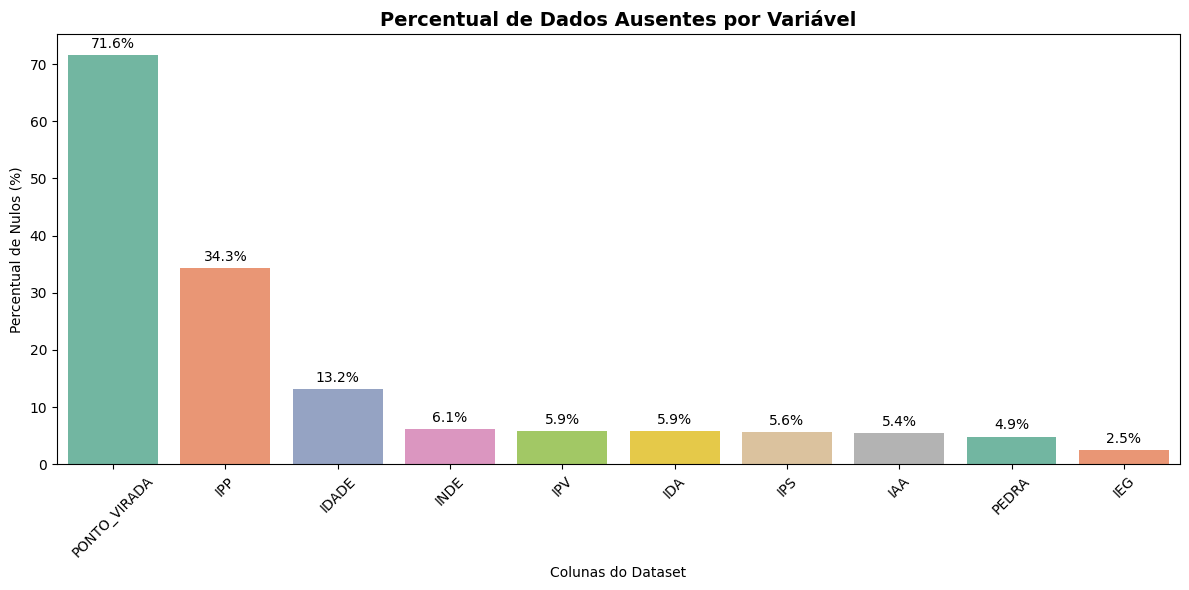

In [ ]:
plt.figure(figsize=(12, 6)) # Cria uma nova figura com tamanho específico para o gráfico
# Calcula o percentual de valores nulos em cada coluna e ordena do maior para o menor
null_perc = (df_unificado.isnull().sum() / len(df_unificado) * 100).sort_values(ascending=False)
# Cria o gráfico de barras e armazena o objeto na variável 'ax' para permitir edições
ax = sns.barplot(x=null_perc.index[:10], y=null_perc.values[:10], palette='Set2') 

# Adiciona o rótulo de dados em TODAS as colunas do gráfico
for container in ax.containers: # Percorre todos os grupos de barras do gráfico
    ax.bar_label(container, fmt='%.1f%%', padding=3) # Adiciona o texto com 1 casa decimal e símbolo de %

plt.title('Percentual de Dados Ausentes por Variável', fontsize=14, fontweight='bold') # Define o título em negrito
plt.ylabel('Percentual de Nulos (%)') # Define o nome do eixo vertical
plt.xlabel('Colunas do Dataset') # Define o nome do eixo horizontal
plt.xticks(rotation=45) # Inclina os nomes das colunas em 45 graus para facilitar a leitura
plt.tight_layout() # Ajusta o espaçamento para evitar cortes no gráfico ou legendas
plt.show() # Exibe o gráfico finalizado na tela

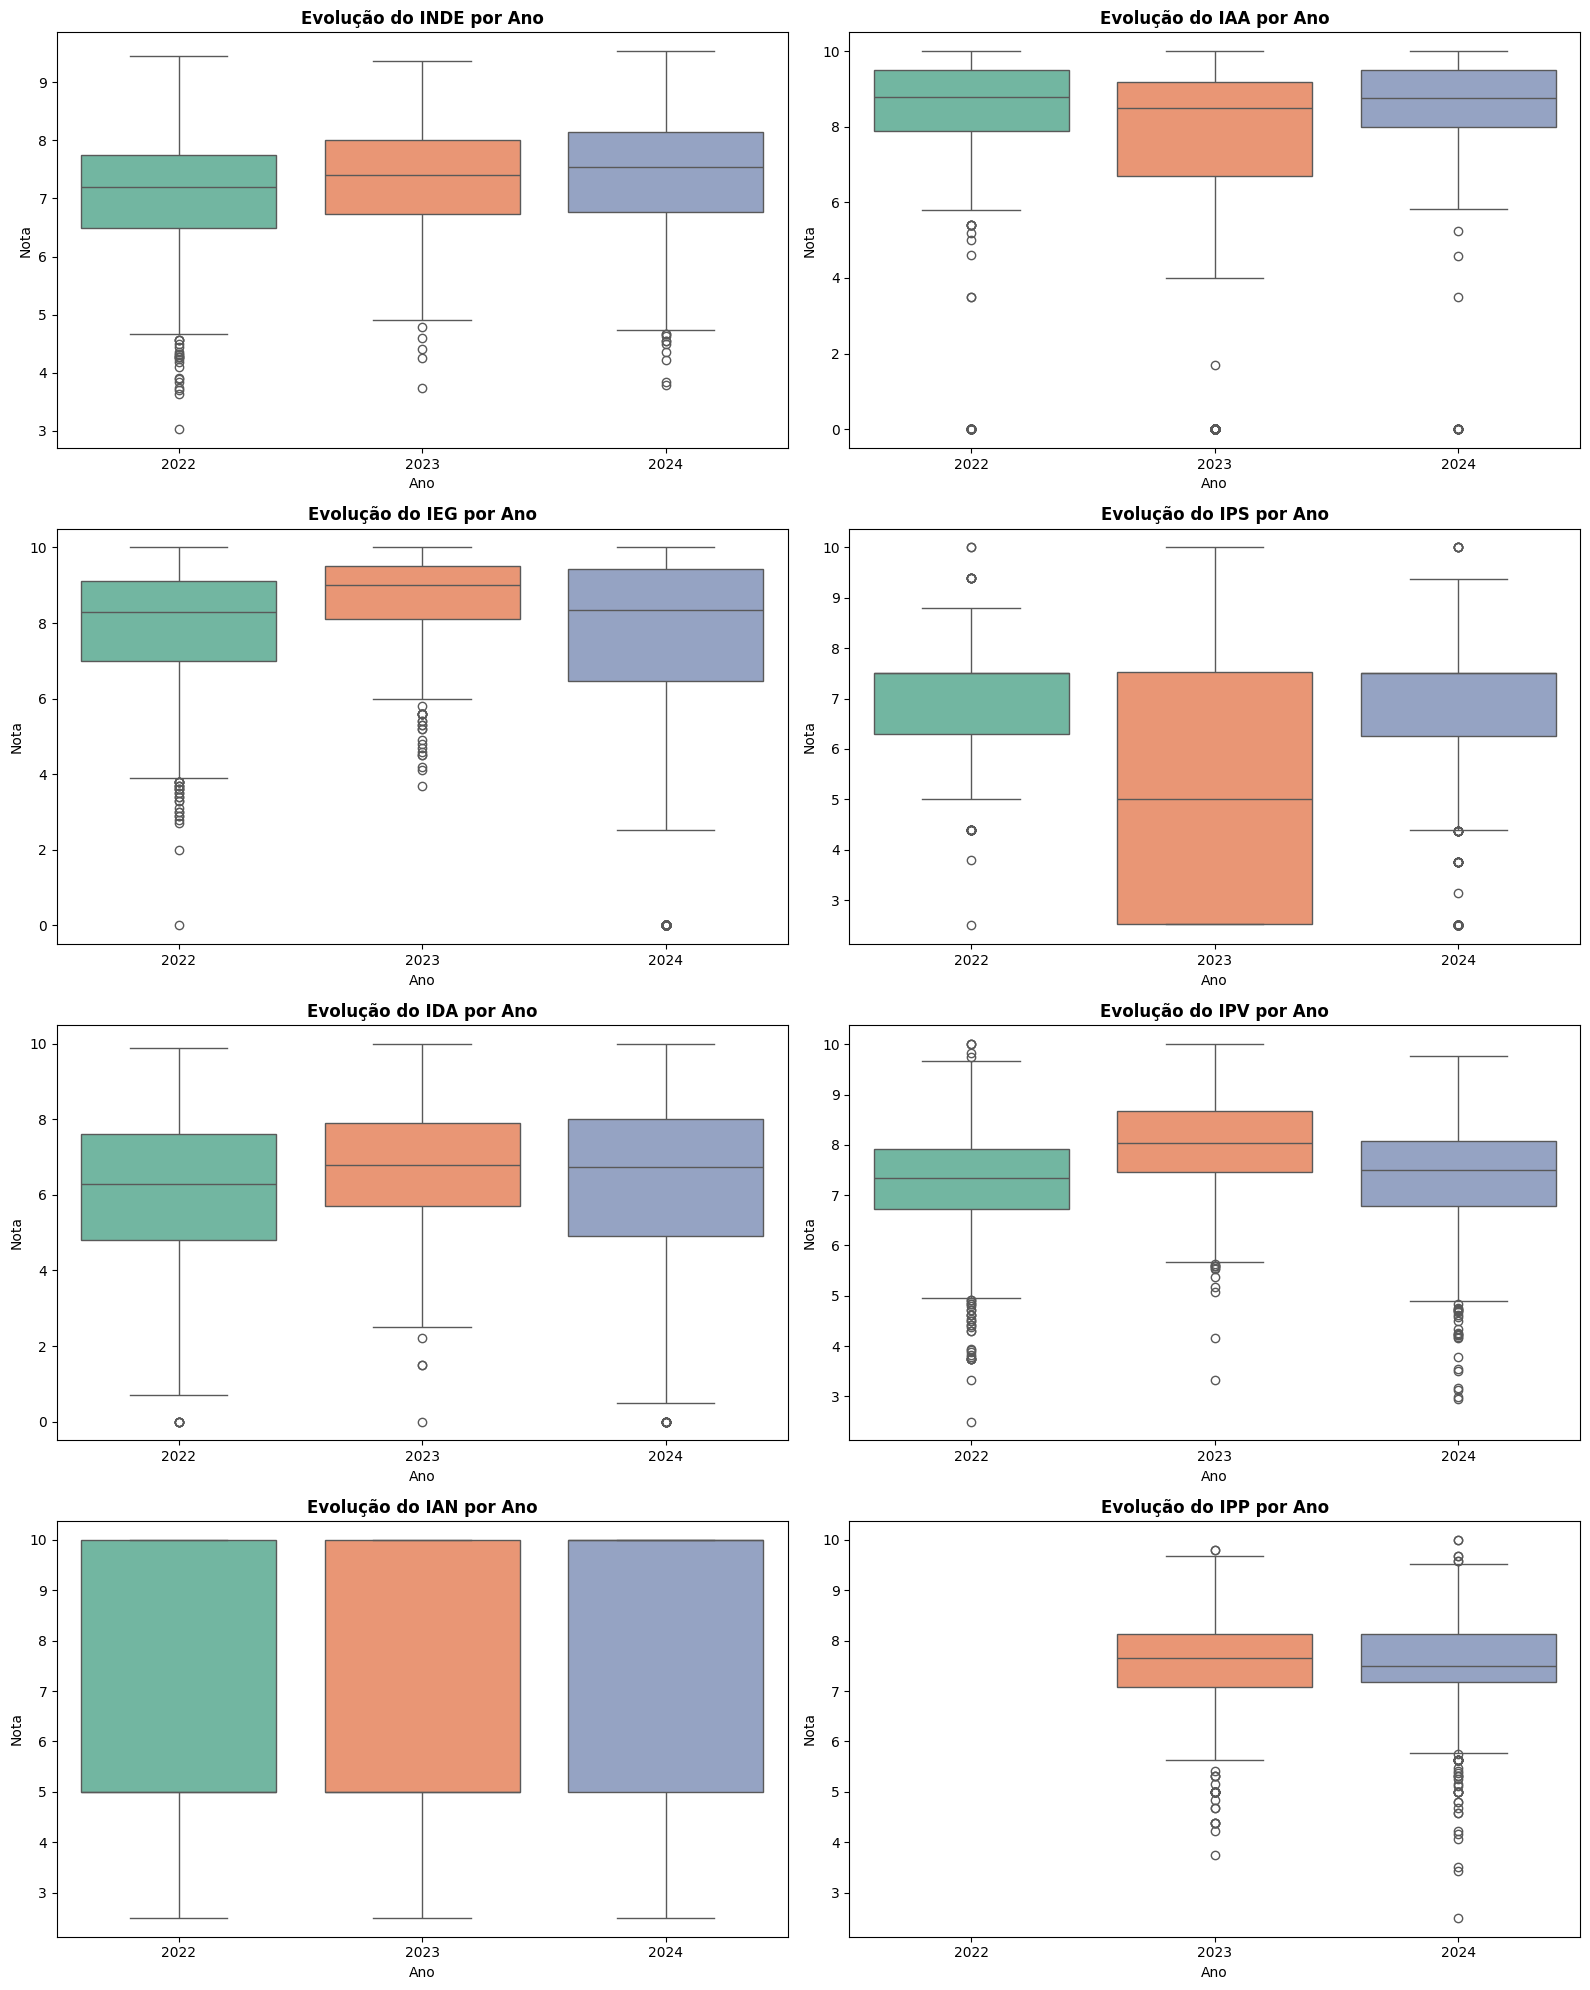

In [ ]:
# 2. Lista de indicadores para a análise
indicadores = ['INDE', 'IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IAN', 'IPP']

# 3. Tratamento de dados: Garantir que todos os indicadores sejam numéricos
for col in indicadores:
    df_unificado[col] = pd.to_numeric(df_unificado[col], errors='coerce')

# 4. Tratamento do ANO: Converter para string para evitar espaços vazios no gráfico
df_unificado['ANO'] = df_unificado['ANO'].astype(str)

# 5. Configuração da grade de subplots (4 linhas x 2 colunas)
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten() # Transforma a matriz de eixos em uma lista simples para facilitar o loop

# 6. Loop para criar um boxplot para cada indicador
for i, col in enumerate(indicadores):
    # sns.boxplot: Cria o gráfico de caixa
    # data=df_unificado: Fonte dos dados
    # x='ANO': Categorias no eixo horizontal
    # y=col: O indicador atual no eixo vertical
    # ax=axes[i]: Define em qual "quadrado" da grade o gráfico será desenhado
    sns.boxplot(data=df_unificado, x='ANO', y=col, ax=axes[i], palette='Set2', order=['2022', '2023', '2024'])
    
    # Define o título de cada subgráfico
    axes[i].set_title(f'Evolução do {col} por Ano', fontsize=12, fontweight='bold')
    # Nomeia os eixos
    axes[i].set_xlabel('Ano')
    axes[i].set_ylabel('Nota')

# 7. Ajuste final de layout para evitar sobreposição de títulos
plt.tight_layout()
plt.show()

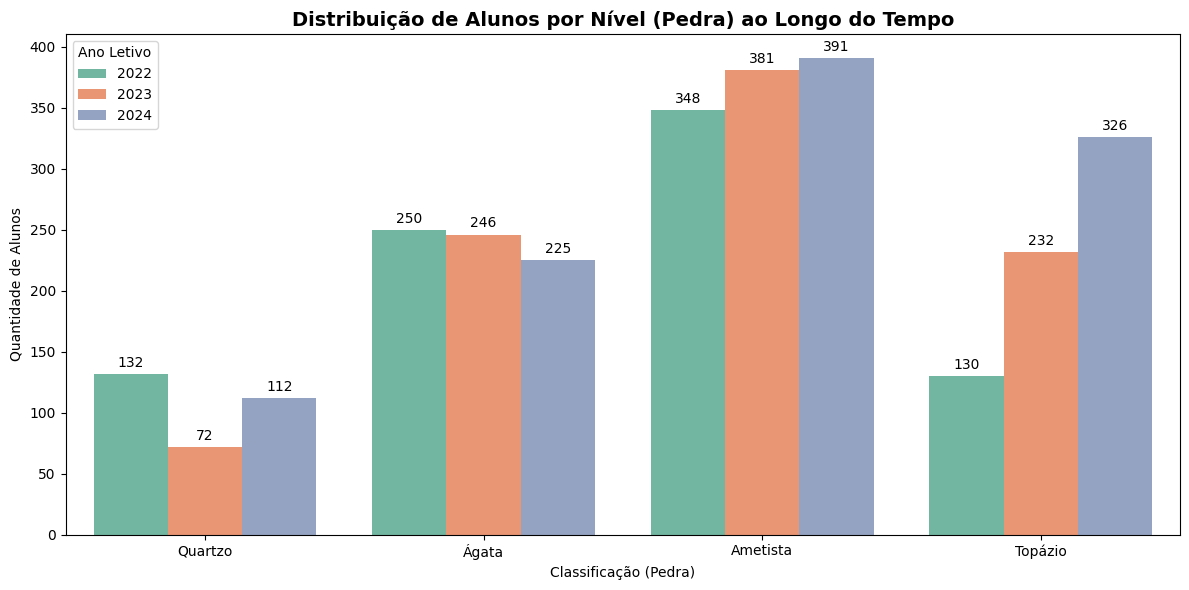

In [32]:
# Define a ordem lógica das pedras do nível mais baixo ao mais alto
ordem = ['Quartzo', 'Ágata', 'Ametista', 'Topázio'] 
# Filtra o dataframe para conter apenas as pedras que estão na nossa lista de interesse
df_filtro_pedras = df_unificado[df_unificado['PEDRA'].isin(ordem)] 
plt.figure(figsize=(12, 6)) # Cria a figura para o gráfico de contagem
# Cria o gráfico (countplot) e armazena em 'ax' para permitir a inclusão dos rótulos
ax = sns.countplot(data=df_filtro_pedras, x='PEDRA', hue='ANO', order=ordem, palette='Set2') 

# Adiciona o rótulo de dados (contagem) em TODAS as barras do gráfico
for container in ax.containers: # Percorre os grupos de barras de cada ano (2022, 2023, 2024)
    ax.bar_label(container, fontsize=10, padding=3) # Adiciona o número exato sobre cada barra

plt.title('Distribuição de Alunos por Nível (Pedra) ao Longo do Tempo', fontsize=14, fontweight='bold') # Adiciona o título em negrito
plt.xlabel('Classificação (Pedra)') # Nomeia o eixo horizontal
plt.ylabel('Quantidade de Alunos') # Nomeia o eixo vertical
plt.legend(title='Ano Letivo') # Adiciona uma legenda para identificar os anos
plt.tight_layout() # Ajusta o layout para evitar cortes
plt.show() # Exibe o gráfico finalizado

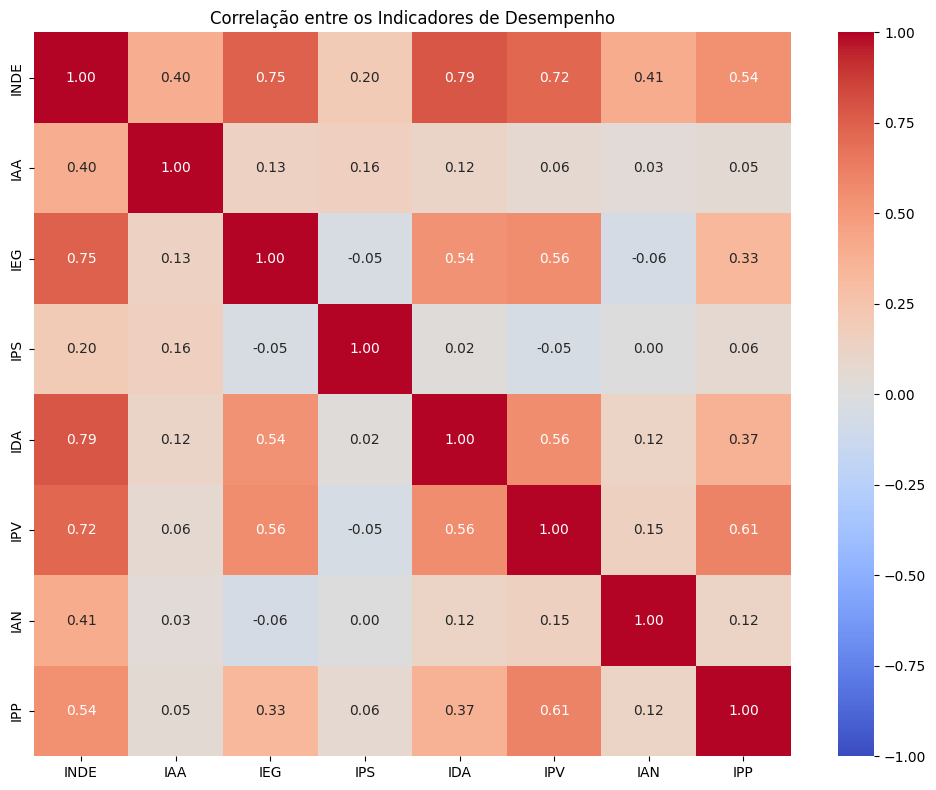

In [23]:
# Lista as colunas numéricas que representam os indicadores educacionais
indicadores = ['INDE', 'IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IAN', 'IPP'] 
# Calcula a matriz de correlação de Pearson entre esses indicadores
matriz_corr = df_unificado[indicadores].corr() 
plt.figure(figsize=(10, 8)) # Define o tamanho da figura (mais quadrada para matrizes)
# Cria um mapa de calor (heatmap) com os valores de correlação escritos dentro das células (annot=True)
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1) 
plt.title('Correlação entre os Indicadores de Desempenho') # Define o título do heatmap
plt.tight_layout() # Ajusta o layout final
plt.show() # Exibe o mapa de calor

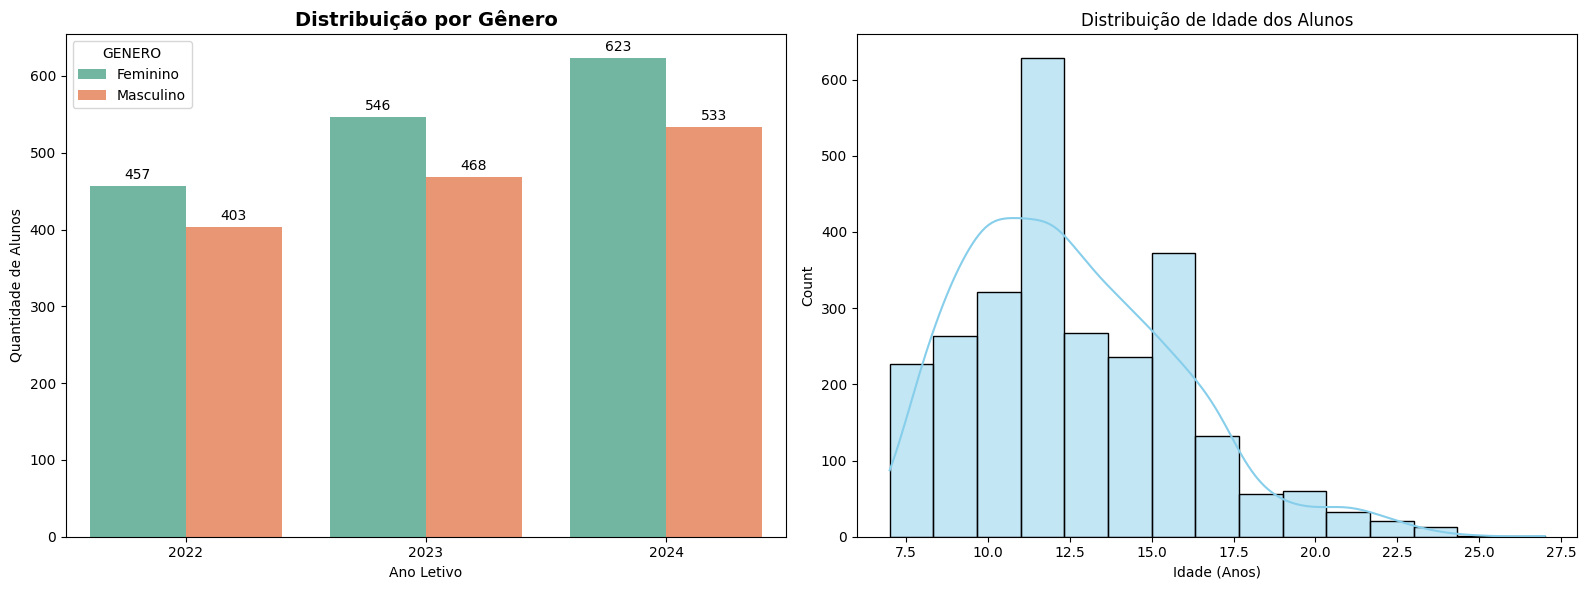

In [33]:
# Cria uma figura dividida em 1 linha e 2 colunas para colocar dois gráficos lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6)) 

# Gráfico da esquerda: Contagem por gênero
ax1 = sns.countplot(data=df_unificado, x='ANO', hue='GENERO', ax=ax1, palette='Set2') # Cria o gráfico de contagem por gênero e ano no primeiro eixo
for container in ax1.containers: # Percorre todos os grupos de barras (Masculino e Feminino) de cada ano
    ax1.bar_label(container, fontsize=10, padding=3) # Adiciona o valor exato da contagem em cima de cada barra
ax1.set_title('Distribuição por Gênero', fontsize=14, fontweight='bold') # Define o título do subgráfico em negrito
ax1.set_xlabel('Ano Letivo') # Define o rótulo do eixo X (Anos)
ax1.set_ylabel('Quantidade de Alunos') # Define o rótulo do eixo Y (Contagem)

# Gráfico da direita: Histograma de idades
# Plota a distribuição das idades removendo nulos e adicionando a linha de tendência (kde)
sns.histplot(df_unificado['IDADE'].dropna(), bins=15, kde=True, ax=ax2, color='skyblue') 
ax2.set_title('Distribuição de Idade dos Alunos') # Título do segundo subgráfico
ax2.set_xlabel('Idade (Anos)') # Rótulo X do segundo subgráfico

plt.tight_layout() # Garante que os dois gráficos não se sobreponham
plt.show() # Exibe os gráficos demográficos

## Questionários

1. Adequação do nível (IAN): Qual é o perfil geral de defasagem dos alunos (IAN) e como ele evolui ao longo do ano? (Ex.: quantos alunos estão moderadamente ou severamente defasados?)

2. Desempenho acadêmico (IDA): O desempenho acadêmico médio (IDA) está melhorando, estagnado ou caindo ao longo das fases e anos?

3. Engajamento nas atividades (IEG): O grau de engajamento dos alunos (IEG) tem relação direta com seus indicadores de desempenho (IDA) e do ponto de virada (IPV)?

4. Autoavaliação (IAA): As percepções dos alunos sobre si mesmos (IAA) são coerentes com seu desempenho real (IDA) e engajamento (IEG)?

5. Aspectos psicossociais (IPS): Há padrões psicossociais (IPS) que antecedem quedas de desempenho acadêmico ou de engajamento?

6. Aspectos psicopedagógicos (IPP): As avaliações psicopedagógicas (IPP) confirmam ou contradizem a defasagem identificada pelo IAN?

7. Ponto de virada (IPV): Quais comportamentos - acadêmicos, emocionais ou de engajamento - mais influenciam o IPV ao longo do tempo?

8. Multidimensionalidade dos indicadores: Quais combinações de Quais combinações de indicadores (IDA + IEG + IPS + IPP) elevam mais a nota global do aluno (INDE)?